# Normal Mode Sampling
The python library ProDy was incorporated in pysingfel to add the ability to perform the normal mode analysis (NMA) of a given protein structure read from a PDB file. In a nutshell, NMA is performed in 3 steps: 
- first, an Elastic Network Model (ENM) of the structure is built by defining elastic springs between pairs of atoms that are within a given cutoff distance. Both the spring constant and the cutoff distances are user-defined. This ENM therefore embodies the harmonic energy potential around the structure and dictates how it fluctuates around it. 
- In a second step, the Hessian matrix of the energy potential is built - it contains the second derivative of the potential with respect to the atomic cartesian coordinates. 
- In a final step, the Hessian matrix just built is diagonalized, yielding a user-defined number of eigenvectors and their associated eigenvalues. Each eigenvector can be thought as a set of difference vectors at each atom, whose direction defines the line onto which the atom fluctuates and whose norm defines the amplitude of that fluctuation. The associated eigenvalue is related to the frequency of the fluctuation, and its inverse to the extent of the fluctuation. Together, this eigenpair defines a normal mode. The first normal mode has the lowest frequency and corresponds to larger and collective deformations. Subsequent modes have increasing associated frequencies and correspond to more and more localized deformations. 

Once NMA is performed, the normal modes can be used to generate random structural decoys as linear combinations of a user-defined number of normal modes. Diffraction patterns for each decoy can then be readily computed.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pysingfel as ps

## Inputs and Parameters

In [3]:
input_dir='../input'
pdbfile=input_dir+'/pdb/2cex.pdb'
beamfile=input_dir+'/beam/amo86615.beam'
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'

## Definition of the beam, the detector and the particle

### Beam
We illustrate below how to define the beam, retrieve its flux and change it eventually

In [4]:
beam = ps.Beam(beamfile)

In [5]:
increase_factor = 1e3
print('BEFORE: # of photons per pulse {}'.format(beam.get_photons_per_pulse()))
print('>>> Increasing the number of photons per pulse by a factor {}'.format(increase_factor))
beam.set_photons_per_pulse(increase_factor * beam.get_photons_per_pulse())
print('AFTER : # of photons per pulse {}'.format(beam.get_photons_per_pulse()))

BEFORE: # of photons per pulse 1e+12
>>> Increasing the number of photons per pulse by a factor 1000.0
AFTER : # of photons per pulse 1e+15


### Detector
We illustrate below how to define the detector, and change its distance to the sample

In [6]:
det = ps.PnccdDetector(geom=geom, beam=beam)

In [7]:
increase_factor = 0.5
print('BEFORE: Detector distance {} m'.format(det.distance))
print('>>> Increasing the distance by a factor {}'.format(increase_factor))
det.distance = increase_factor * det.distance
print('AFTER : Detector distance {} m'.format(det.distance))

BEFORE: Detector distance 0.581 m
>>> Increasing the distance by a factor 0.5
AFTER : Detector distance 0.2905 m


### Particle
We illustrate below how to build a particle from a PDB file and then deform it using Normal Mode Analysis

In [8]:
particle = ps.Particle()
particle.read_pdb(pdbfile, ff='WK')
print('Number of atoms in particle: {}'.format(particle.get_num_atoms()))

('Unknown element or wrong line: \n', 'HETATM 2364 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  \n')
no symmetry REMARK 350 found
Number of atoms in particle: 2451


## perform SPI Experiment
Let's generate a diffraction pattern of the hydrated object and visualize it

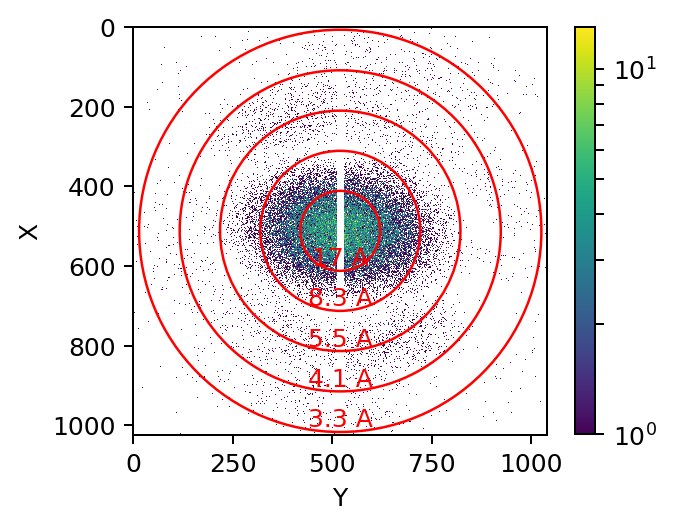

In [9]:
experiment = ps.SPIExperiment(det, beam, particle)
image = experiment.generate_image()
#
fig = plt.figure(figsize=(4, 3), dpi=180)
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
viz.imshow(image)

## Effect of structural deformation on diffraction patterns

First we compute the normal modes of the structure, saving its current state and orientation

In [10]:
particle.gen_normal_modes()
# fix the orientation
orientation = experiment.get_next_orientation()
# save the reference atom positions
atom_pos_save = particle.atom_pos

>>> Computing normal modes with ProDy


Then let's define a series of RMSD values at which we will generate a `num_decoys` decoys using these normal modes, initiate and fill the arrays containing the resulting conformation and their diffraction patterns

In [11]:
rmsd_range = np.arange(1., 11., 3.)
num_decoys = 9
diffraction_patterns = np.zeros((rmsd_range.shape[0], num_decoys, image.shape[0], image.shape[1]))
conformational_state = np.zeros((rmsd_range.shape[0], num_decoys, atom_pos_save.shape[0], atom_pos_save.shape[1]))

In [12]:
irmsd=0
for rmsd in rmsd_range:
    print('Generating decoys at RMSD = {}'.format(rmsd))
    for idecoy in range(num_decoys):
        particle.set_atom_pos(atom_pos_save)
        updated_conformation = particle.update_conformation(rmsd=rmsd)
        particle.set_atom_pos(updated_conformation)
        experiment = ps.SPIExperiment(det, beam, particle, orientations=orientation)
        diffraction_patterns[irmsd, idecoy, ...] = experiment.generate_image()
        conformational_state[irmsd, idecoy, ...] = updated_conformation 
    irmsd += 1

Generating decoys at RMSD = 1.0
Generating decoys at RMSD = 4.0
Generating decoys at RMSD = 7.0
Generating decoys at RMSD = 10.0


#### Visualization
Let's peak which series to visualize, then see the effect on the diffraction patterns and the conformations

In [13]:
irmsd=1

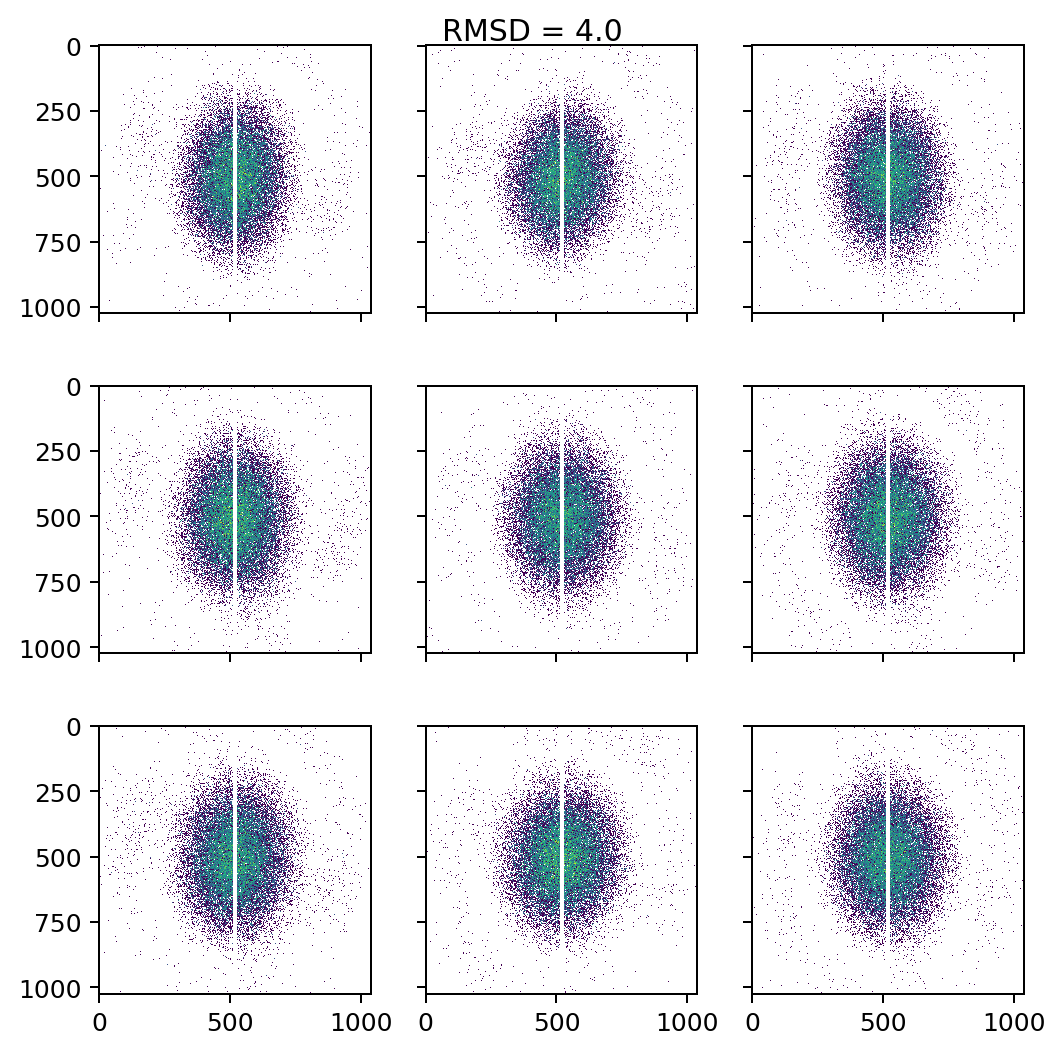

In [14]:
nrows=3
ncols=3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(2*ncols,2*nrows),dpi=180)
plt.suptitle('RMSD = {}'.format(rmsd_range[irmsd]))
idecoy=0
for irow in range(nrows):
    for icol in range(ncols):
        axes[irow,icol].imshow(diffraction_patterns[irmsd,idecoy,...], norm=LogNorm())
        idecoy+=1
plt.tight_layout()

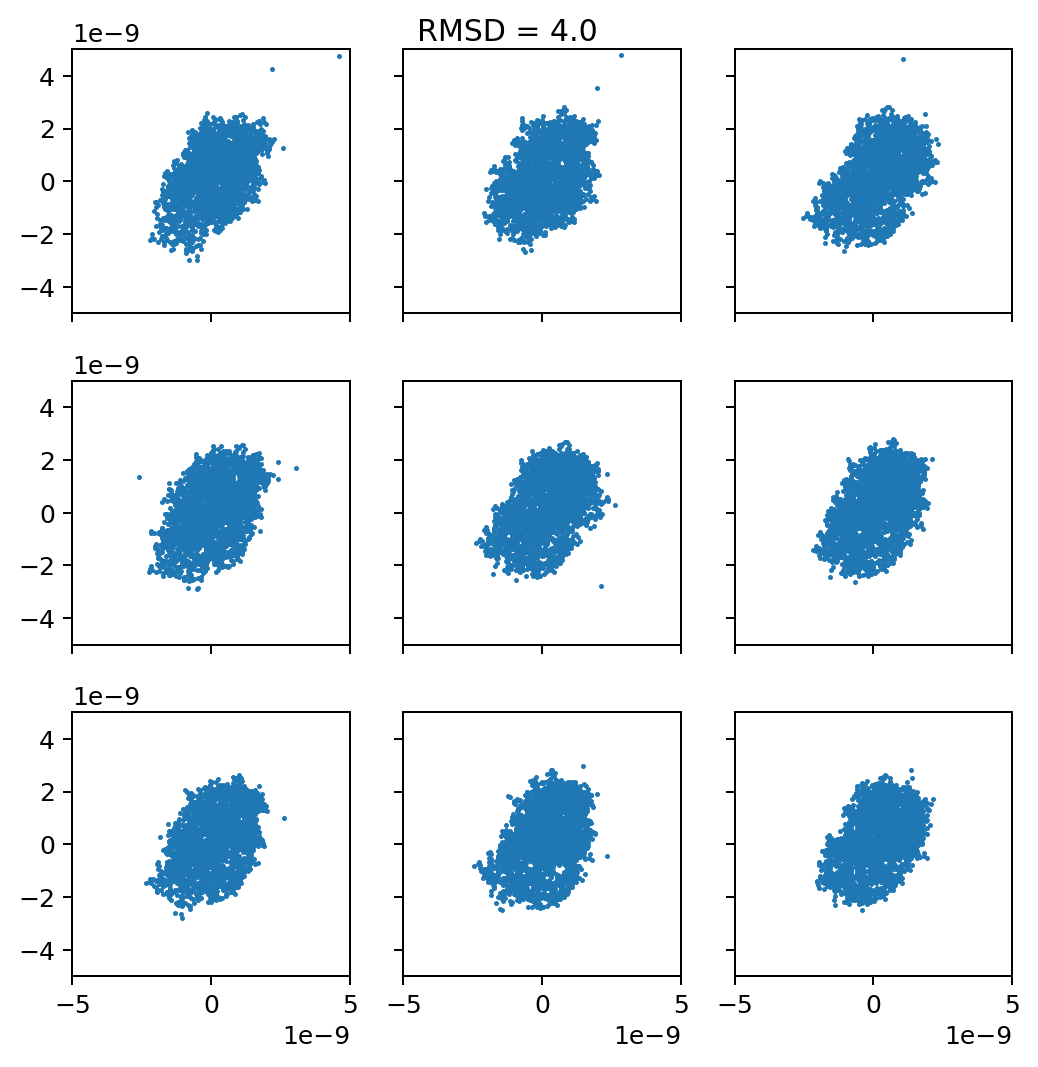

In [15]:
nrows=3
ncols=3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(2*ncols,2*nrows),dpi=180)
plt.suptitle('RMSD = {}'.format(rmsd_range[irmsd]))
idecoy=0
for irow in range(nrows):
    for icol in range(ncols):
        axes[irow,icol].set_ylim((-5e-9, 5e-9))
        axes[irow,icol].set_xlim((-5e-9, 5e-9))
        axes[irow,icol].scatter(conformational_state[irmsd,idecoy,:,0], conformational_state[irmsd,idecoy,:,1],  s=1)
        idecoy+=1
plt.tight_layout()

### Illustration of the effect with SAXS profiles

In [23]:
N = 1000000           # number of particles
resmax = 2. / 10**10  # max. resolution in meters
#
saxs_array = np.zeros((rmsd_range.shape[0], num_decoys, ps.SAXS(particle, N, resmax).qs.shape[0]))
#
irmsd=0
for rmsd in rmsd_range:
    print('Computing SAXS of decoys at RMSD = {}'.format(rmsd))
    for idecoy in range(num_decoys):
        particle.set_atom_pos(conformational_state[irmsd, idecoy, ...] )
        saxs_profile = ps.SAXS(particle, N, resmax)
        qs, saxs_array[irmsd, idecoy, :] = saxs_profile.compute()
    irmsd += 1

Computing SAXS of decoys at RMSD = 1.0
Computing SAXS of decoys at RMSD = 4.0
Computing SAXS of decoys at RMSD = 7.0
Computing SAXS of decoys at RMSD = 10.0


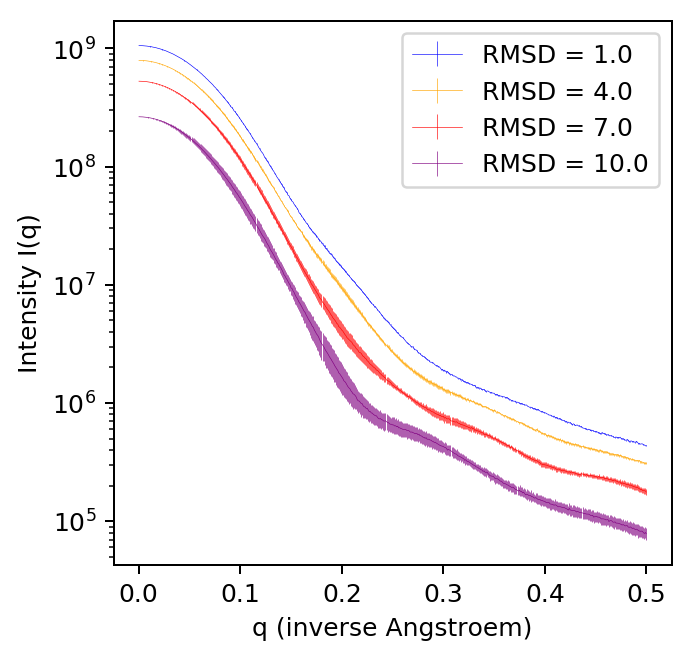

In [24]:
fig = plt.figure(figsize=(4,4),dpi=180)
plt.ylabel('Intensity I(q)')
plt.xlabel('q (inverse Angstroem)')

plt.yscale('log')
irmsd=0
rmsd = rmsd_range[irmsd]
plt.errorbar(qs/10**10, 4*np.mean(saxs_array[irmsd,...], axis=0), yerr=np.std(saxs_array[irmsd,...], axis=0), linewidth=0.25, color='blue', label='RMSD = {}'.format(rmsd))
irmsd=1
rmsd = rmsd_range[irmsd]
plt.errorbar(qs/10**10, 3*np.mean(saxs_array[irmsd,...], axis=0), yerr=np.std(saxs_array[irmsd,...], axis=0), linewidth=0.25, color='orange',label='RMSD = {}'.format(rmsd))
irmsd=2
rmsd = rmsd_range[irmsd]
plt.errorbar(qs/10**10, 2*np.mean(saxs_array[irmsd,...], axis=0), yerr=np.std(saxs_array[irmsd,...], axis=0), linewidth=0.25, color='red',label='RMSD = {}'.format(rmsd))
irmsd=3
rmsd = rmsd_range[irmsd]
plt.errorbar(qs/10**10, np.mean(saxs_array[irmsd,...], axis=0), yerr=np.std(saxs_array[irmsd,...], axis=0), linewidth=0.25, color='purple',label='RMSD = {}'.format(rmsd))

plt.legend()
plt.show()